In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from PIL import Image
import numpy as np

from configs.ve.cifar10_ncsnpp_deep_continuous import get_config
from score_inverse.models.utils import create_model
from score_inverse.models.ema import ExponentialMovingAverage
from score_inverse.tasks.deblur import DeblurTask
from score_inverse.tasks.colorization import ColorizationTask 
from score_inverse.tasks.task import CombinedTask  
from score_inverse.datasets import CIFAR10
from score_inverse.sde import get_sde
from score_inverse.datasets.scalers import get_data_inverse_scaler, get_data_scaler
from score_inverse.sampling import get_corrector, get_predictor
from score_inverse.sampling.inverse import get_pc_inverse_solver

/Users/jadsbai/score-sde-inverse/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
config = get_config()
device = "cuda" if torch.cuda.is_available() else "cpu"
config.model.num_scales = 100
config.eval.batch_size = 4

ckpt_path = "../checkpoints/ve/cifar10_ncsnpp_deep_continuous/checkpoint_12.pth"
loaded_state = torch.load(ckpt_path, map_location=device)

score_model = create_model(config)
score_model.load_state_dict(loaded_state["model"], strict=False)

ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
ema.load_state_dict(loaded_state["ema"])
ema.copy_to(score_model.parameters())

In [4]:
def display_img(im, scale=10):
    w, h = im.size
    display(im.resize((scale * w, scale * h), Image.NEAREST))

def display_sample(sample, scale=10, shape=None):
    samples = np.clip(sample.permute(0, 2, 3, 1).cpu().numpy() * 255.0, 0, 255).astype(np.uint8)
    if samples.shape[-1] == 1:
        im = Image.fromarray(samples[0, :, :, 0])
    else:
        im = Image.fromarray(samples[0])
    display_img(im, scale)

In [25]:
deblur_task = DeblurTask((1, 32, 32), kernel_type="gaussian", kernel_size=3)
colorization_task = ColorizationTask((3, 32, 32))  
combined_task = CombinedTask(colorization_task, deblur_task)
combined_task.to(device)

torch.Size([32, 32])
torch.Size([30, 32])


CombinedTask(
  (task1): ColorizationTask(
    (svd): MemEfficientSVD()
  )
  (task2): DeblurTask(
    (svd): MemEfficientSVD()
  )
  (svd): MemEfficientSVD()
)

In [6]:
dataset = CIFAR10()

Files already downloaded and verified


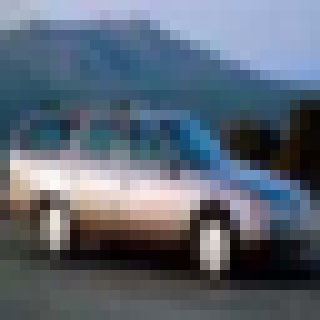

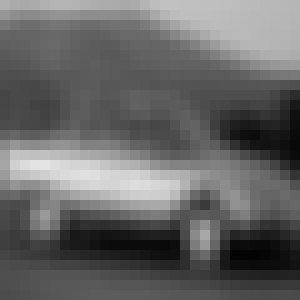

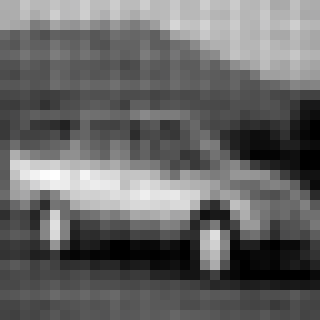

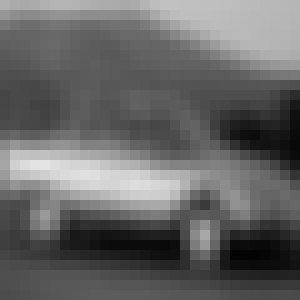

In [26]:

x = dataset[4]
x = x[None, :].to(device)
y = combined_task.forward(x)

x_hat = combined_task.transform_inv(combined_task.mask(combined_task.drop_inv(y)))
y_hat = combined_task.A(x_hat)

display_sample(x)
display_sample(y)
display_sample(x_hat)
display_sample(y_hat)

In [27]:
scaler = get_data_scaler(config)
inverse_scaler = get_data_inverse_scaler(config)
sde, sampling_eps = get_sde(config)

sampling_shape = (config.eval.batch_size, config.data.num_channels, config.data.image_size, config.data.image_size)
predictor = get_predictor(config.sampling.predictor.lower())
corrector = get_corrector(config.sampling.corrector.lower())
sampling_fn = get_pc_inverse_solver(
    sde=sde,
    shape=sampling_shape,
    predictor=predictor,
    corrector=corrector,
    inverse_scaler=inverse_scaler,
    snr=config.sampling.snr,
    n_steps=config.sampling.n_steps_each,
    probability_flow=config.sampling.probability_flow,
    continuous=config.training.continuous,
    denoise=config.sampling.noise_removal,
    eps=sampling_eps,
    device=device,
    inverse_task=combined_task,
    lambda_=0.1,
)

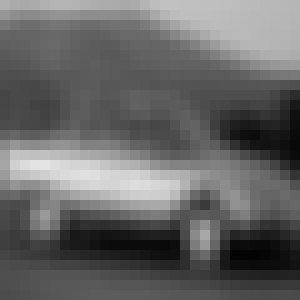

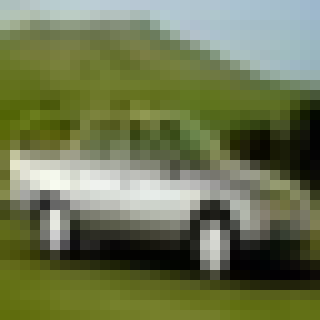

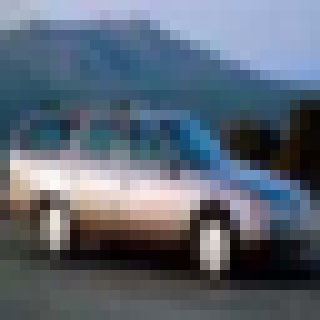

In [28]:
sample, n = sampling_fn(score_model, y.to(device))
display_sample(y)
display_sample(sample)
display_sample(x)